# Install Some Libraries

In [1]:
%%capture
!apt-get update && apt-get install openjdk-8-jdk
!pip -qq install datasets sentencepiece transformers py-vncorenlp sentence-transformers numpy seaborn scikit-learn
!pip install deep-translator

# Data Preparation

In [2]:
from datasets import load_dataset,Dataset

HUGGINGFACE_PATH = "uitnlp/vietnamese_students_feedback"
NUM_CORE = 2 # Colab Maximum Core

train_dataset = load_dataset(
    path=HUGGINGFACE_PATH,
    num_proc=NUM_CORE,
    split="train",
    verification_mode="no_checks",
    trust_remote_code=True,
    cache_dir="cache"
)

test_dataset = load_dataset(
    path=HUGGINGFACE_PATH,
    num_proc=NUM_CORE,
    split="test",
    verification_mode="no_checks",
    trust_remote_code=True,
    cache_dir="cache"
)

README.md:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

vietnamese_students_feedback.py:   0%|          | 0.00/4.97k [00:00<?, ?B/s]

Setting num_proc from 2 back to 1 for the train split to disable multiprocessing as it only contains one shard.


Generating train split:   0%|          | 0/11426 [00:00<?, ? examples/s]

Setting num_proc from 2 back to 1 for the validation split to disable multiprocessing as it only contains one shard.


Generating validation split:   0%|          | 0/1583 [00:00<?, ? examples/s]

Setting num_proc from 2 back to 1 for the test split to disable multiprocessing as it only contains one shard.


Generating test split:   0%|          | 0/3166 [00:00<?, ? examples/s]

In [3]:
train_data_df=train_dataset.to_pandas()
test_data_df=test_dataset.to_pandas()

In [4]:
train_data_df.info()
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11426 entries, 0 to 11425
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   11426 non-null  object
 1   sentiment  11426 non-null  int64 
 2   topic      11426 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 267.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3166 entries, 0 to 3165
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   3166 non-null   object
 1   sentiment  3166 non-null   int64 
 2   topic      3166 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 74.3+ KB


<Axes: xlabel='sentiment', ylabel='count'>

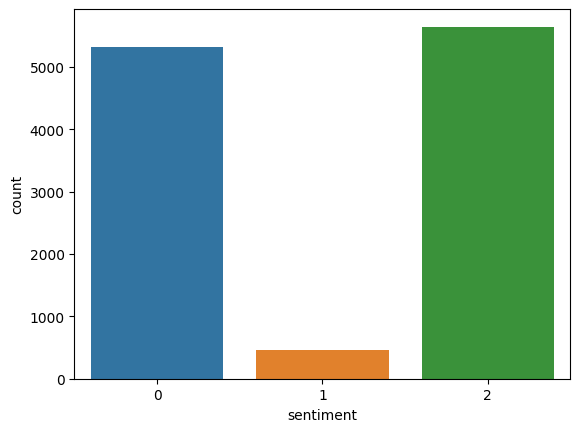

In [5]:
import seaborn as sns
sns.countplot(x='sentiment', data=train_data_df)
sns.countplot(x='sentiment', data=test_data_df)

We will select sample a limited number of docs to finetune the model

In [6]:
# Filter out items with empty fields
filtered_train_ds=train_dataset.filter(lambda x: x['sentence'].strip())
filtered_test_ds=test_dataset.filter(lambda x: x['sentence'].strip())

Filter:   0%|          | 0/11426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3166 [00:00<?, ? examples/s]

Download py_vncorenlp model

In [7]:
import py_vncorenlp
import os
VNCORENLP_SAVEDIR=os.path.abspath("cache/vncorenlp")
os.makedirs(VNCORENLP_SAVEDIR,exist_ok=True)
py_vncorenlp.download_model(save_dir=VNCORENLP_SAVEDIR)

### Preprocessing data: Tone normalization and Word segmentation

Warning: `py_vncorenlp` is a wrapper around the java package, once up and running it change the current directory to the location of the downloaded weights. Therefore, we need to change the working directory back to the initial destination. Otherwise, relative paths will be messed up.

In [ ]:
import os
# Save the current working dir
previous_working_dir=os.path.abspath(os.getcwd())

rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=VNCORENLP_SAVEDIR)
tone_dict_map  =  {  "òa":  "oà",  "Òa":  "Oà",  "ÒA":  "OÀ",  "óa":  "oá",  "Óa":  "Oá",  "ÓA":  "OÁ",  "ỏa":  "oả",  "Ỏa":  "Oả",  "ỎA":  "OẢ",  "õa":  "oã",  "Õa":  "Oã",  "ÕA":  "OÃ",  "ọa":  "oạ",  "Ọa":  "Oạ",  "ỌA":  "OẠ",  "òe":  "oè",  "Òe":  "Oè",  "ÒE":  "OÈ",  "óe":  "oé",  "Óe":  "Oé",  "ÓE":  "OÉ",  "ỏe":  "oẻ",  "Ỏe":  "Oẻ",  "ỎE":  "OẺ",  "õe":  "oẽ",  "Õe":  "Oẽ",  "ÕE":  "OẼ",  "ọe":  "oẹ",  "Ọe":  "Oẹ",  "ỌE":  "OẸ",  "ùy":  "uỳ",  "Ùy":  "Uỳ",  "ÙY":  "UỲ",  "úy":  "uý",  "Úy":  "Uý",  "ÚY":  "UÝ",  "ủy":  "uỷ",  "Ủy":  "Uỷ",  "ỦY":  "UỶ",  "ũy":  "uỹ",  "Ũy":  "Uỹ",  "ŨY":  "UỸ",  "ụy":  "uỵ",  "Ụy":  "Uỵ",  "ỤY":  "UỴ",  }
def tone_normalize(text, dict_map=tone_dict_map):
    for i, j in dict_map.items():
        text = text.replace(i, j)
    return text
def preprocess_data(text):
    text=tone_normalize(text)
    return rdrsegmenter.word_segment(text)
# Since py_vncorenlp is a light wrapper around the Java package,
# it does not work out of the box with python multiprocessing.
# Therefore, it is recommended to word segment data before finetuning
# Or use another library (eg: pyvy) in case of training from scratch
preprocessed_train_data=train_dataset.map(lambda x:{
    "segmented":preprocess_data(x['sentence']),
})

preprocessed_test_data=test_dataset.map(lambda x:{
    "segmented":preprocess_data(x['sentence']),
})
# Return to the previous working dir
os.chdir(previous_working_dir)

In [ ]:
preprocessed_train_data.to_json("./preprocessed_train_data.jsonl")
preprocessed_test_data.to_json("./preprocessed_test_data.jsonl")

# Load model

We wil load model and tokenizer from huggingface and test inferencing on our data

In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoModelForSeq2SeqLM
import torch

model_name = "VietAI/vit5-base" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
vit5_model = AutoModel.from_pretrained(model_name)

# Finetuning for sentimental analysis

Sentiment analysis is the process of analyzing text to determine if the emotional tone of the message is positive, negative, or neutral. We will use PhoBert to encode texts into vectors and classify them into the 3 sentimental classes.

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
input_data=load_dataset("json",data_files="./preprocessed_train_data.jsonl",cache_dir="cache",split="train")
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base",cache_dir="cache")
def tokenize_data(item):
    query=str(item['segmented'])
    return tokenizer.encode_plus(query, truncation= True, max_length=128, padding='max_length', return_attention_mask=True, return_token_type_ids=False)
tokenized_dataset=input_data.map(tokenize_data)
print("Data length: ", len(tokenized_dataset))
print(torch.tensor(tokenized_dataset['sentiment']).dtype)

In [ ]:
from torch import nn
from transformers import AutoModel

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes=3):
        super(SentimentClassifier, self).__init__()
        self.vit5 = AutoModel.from_pretrained("VietAI/vit5-base", cache_dir="cache")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.vit5.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        # Lấy biểu diễn từ mô hình encoder
        output = self.vit5(
            input_ids=input_ids,
            decoder_input_ids=decoder_input_ids,
            attention_mask=attention_mask,
            return_dict=True  # Sử dụng return_dict=True để dễ truy xuất
        )

        # Lấy biểu diễn trung bình từ output của encoder
        hidden_state = output.last_hidden_state  # Dạng [batch_size, seq_len, hidden_size]
        pooled_output = hidden_state[:, 0]  # Lấy token [CLS] hoặc có thể pooling theo cách khác

        # Áp dụng dropout và lớp fully connected
        x = self.drop(pooled_output)
        x = self.fc(x)
        return x

In [ ]:
def train_model(model, lr, EPOCHS, BATCH_SIZE, device, tokenized_dataset):
    print(f"Training Learning Rate = {lr}, EPOCHS = {EPOCHS}, BATCH_SIZE = {BATCH_SIZE} ")
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    model.to(device)

    lr_scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(tokenized_dataset)*EPOCHS
    )
    DATASET_LEN=len(tokenized_dataset)
    for epoch in range(EPOCHS):
        losses = []
        correct = 0
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print(u'\u2500' * 10)
        for i in tqdm(range(0,DATASET_LEN,BATCH_SIZE),desc=f'Epoch {epoch+1}/{EPOCHS}'):
            items=tokenized_dataset[i:min(i+BATCH_SIZE,DATASET_LEN)]
            input_ids = torch.tensor(items['input_ids']).to(device)
            decoder_input_ids = torch.tensor([[tokenizer.pad_token_id]] * input_ids.size(0)).to(device)
            attention_mask = torch.tensor(items['attention_mask']).to(device)
            targets = (torch.tensor(items['sentiment'])).to(device)

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                decoder_input_ids=decoder_input_ids
            )
            loss = criterion(outputs, targets)
            _, pred = torch.max(outputs, dim=1)

            correct += torch.sum(pred == targets)
            losses.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            lr_scheduler.step()

        print(f'Train Accuracy: {correct.double()/DATASET_LEN} Loss: {np.mean(losses)}')

In [ ]:
from datasets import load_dataset

test_data = load_dataset("json",data_files="./preprocessed_test_data.jsonl",cache_dir="cache",split="train")
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base",cache_dir="cache")
def tokenize_data(item):
    query=str(item['segmented'])
    return tokenizer.encode_plus(query, truncation= True, max_length=128, padding='max_length', return_attention_mask=True, return_token_type_ids=False)
tokenized_test_dataset=test_data.map(tokenize_data)
DATASET_LEN = len(tokenized_test_dataset)
CLASS_MAP={0:"NEGATIVE",1:"NEUTRAL",2:"POSITIVE"}

def test_model(model, BATCH_SIZE, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for i in range(0,DATASET_LEN,BATCH_SIZE):
            items=tokenized_test_dataset[i:min(i+BATCH_SIZE,DATASET_LEN)]
            input_ids = torch.tensor(items['input_ids']).to(device)
            decoder_input_ids = torch.tensor([[tokenizer.pad_token_id]] * input_ids.size(0)).to(device)
            attention_mask = torch.tensor(items['attention_mask']).to(device)
            targets = (torch.tensor(items['sentiment'])).to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                decoder_input_ids=decoder_input_ids
            )
            _, preds = torch.max(outputs, dim=1)
            correct += torch.sum(preds == targets)
    
    print(f"Model validate accuracy: {correct.double() / DATASET_LEN * 100}%")

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import numpy as np
from tqdm import tqdm
import torch

lr_list = [5e-5, 1e-4]
EPOCHS_LST=[5, 10]
BATCH_SIZE_LST=[16, 32]
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for lr in lr_list:
    for BATCH_SIZE in BATCH_SIZE_LST:
        for EPOCHS in EPOCHS_LST:
            model = SentimentClassifier()
            train_model(model, lr, EPOCHS, BATCH_SIZE, device, tokenized_dataset)
            test_model(model, BATCH_SIZE, device)

# Test trained model

In [ ]:
def infer(text,device='cpu'):
    text = preprocess_data(text)

    tokenized_text = tokenizer(
        text,
        max_length=128,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )
    input_ids = tokenized_text['input_ids'].to(device)
    attention_mask = tokenized_text['attention_mask'].to(device)
    decoder_input_ids = torch.tensor([[tokenizer.pad_token_id]] * input_ids.size(0)).to(device)
    output = model(input_ids=input_ids,attention_mask=attention_mask, decoder_input_ids=decoder_input_ids)
    _, y_pred = torch.max(output, dim=1)
    return int(y_pred[0])

query="đẹp quá"
result=infer(query, device)
print(f'Sentiment: {CLASS_MAP[result]}')